# Higgs boson observed decaying to b quarks

Sample with jet, track and secondary vertex properties for Hbb tagging ML studies HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC

## Description

The dataset consists of particle jets extracted from simulated proton-proton collision events at a center-of-mass energy of 13 TeV generated with Pythia 8. It has been produced for developing machine-learning algorithms to differentiate jets originating from a Higgs boson decaying to a bottom quark-antiquark pair (Hbb) from quark or gluon jets originating from quantum chromodynamic (QCD) multijet production.

The reconstructed jets are clustered using the anti-kT algorithm with R=0.8 from particle flow (PF) candidates (AK8 jets). The standard L1+L2+L3+residual jet energy corrections are applied to the jets and pileup contamination is mitigated using the charged hadron subtraction (CHS) algorithm. Features of the AK8 jets with transverse momentum pT > 200 GeV and pseudorapidity |η| < 2.4 are provided. Selected features of inclusive (both charged and neutral) PF candidates with pT > 0.95 GeV associated to the AK8 jet are provided. Additional features of charged PF candidates (formed primarily by a charged particle track) with pT > 0.95 GeV associated to the AK8 jet are also provided. Finally, additional features of reconstructed secondary vertices (SVs) associated to the AK8 jet (within ∆R < 0.8) are also provided.


https://opendata.cern.ch/record/12102#


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import tables


from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.metrics import roc_curve, auc

TensorFlow version: 2.10.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
# 27 features
features = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [4]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    return feature_array, label_array

In [5]:
f_0, l_0 = get_features_labels('ntuple_merged_1.h5')
f_1, l_1 = get_features_labels('ntuple_merged_2.h5')
f_2, l_2 = get_features_labels('ntuple_merged_3.h5')
f_3, l_3 = get_features_labels('ntuple_merged_4.h5')
f_4, l_4 = get_features_labels('ntuple_merged_6.h5')

In [6]:
train_features = np.concatenate((f_0, f_1, f_2, f_3, f_4), axis=0)
train_labels = np.concatenate((l_0, l_1, l_2, l_3, l_4), axis=0)

In [7]:
test_features, test_labels = get_features_labels('ntuple_merged_0.h5')

In [8]:
print('Features shape: ', train_features.shape)
print('Labels shape: ', train_labels.shape)

Features shape:  (314628, 27)
Labels shape:  (314628, 2)


In [9]:
print('Test Features shape: ', test_features.shape)
print('Test Labels shape: ', test_labels.shape)

Test Features shape:  (62991, 27)
Test Labels shape:  (62991, 2)


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)).shuffle(train_features.shape[0]).batch(1024)

test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(1024)

In [11]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.bn = BatchNormalization()
        self.d1 = Dense(64, activation='relu')
        self.d2 = Dense(32, activation='relu')
        self.d3 = Dense(32, activation='relu')
        self.d4 = Dense(nlabels, activation='softmax')

    def call(self, x):
        x = self.bn(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return self.d4(x)

# Create an instance of the model
model = MyModel()

In [12]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [14]:
@tf.function
def train_step(features, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(features, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [15]:
@tf.function
def test_step(features, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(features, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [16]:
EPOCHS = 20

epoch_train_accuracy = []
epoch_test_accuracy = []
epoch_train_loss = []
epoch_test_loss = []



for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for train_feat, train_lab in train_ds:
        train_step(train_feat, train_lab)

    for test_feat, test_lab in test_ds:
        test_step(test_feat, test_lab)

    epoch_train_accuracy.append(train_accuracy.result() * 100)
    epoch_test_accuracy.append(test_accuracy.result() * 100)
    
    epoch_train_loss.append(train_loss.result())
    epoch_test_loss.append(test_loss.result())
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
      )

Epoch 1, Loss: 0.39204734563827515, Accuracy: 82.75614166259766, Test Loss: 0.352396160364151, Test Accuracy: 85.02326202392578
Epoch 2, Loss: 0.34956124424934387, Accuracy: 85.0960464477539, Test Loss: 0.3477725088596344, Test Accuracy: 85.13755798339844
Epoch 3, Loss: 0.3444622755050659, Accuracy: 85.37606811523438, Test Loss: 0.33950677514076233, Test Accuracy: 85.64239501953125
Epoch 4, Loss: 0.34236016869544983, Accuracy: 85.4358139038086, Test Loss: 0.33888372778892517, Test Accuracy: 85.67732238769531
Epoch 5, Loss: 0.3399742543697357, Accuracy: 85.56707763671875, Test Loss: 0.3380475342273712, Test Accuracy: 85.7535171508789
Epoch 6, Loss: 0.3387550115585327, Accuracy: 85.59219360351562, Test Loss: 0.3356362283229828, Test Accuracy: 85.77256774902344
Epoch 7, Loss: 0.3378249704837799, Accuracy: 85.70280456542969, Test Loss: 0.3348582684993744, Test Accuracy: 85.8074951171875
Epoch 8, Loss: 0.3370036780834198, Accuracy: 85.72187042236328, Test Loss: 0.33372166752815247, Test Acc

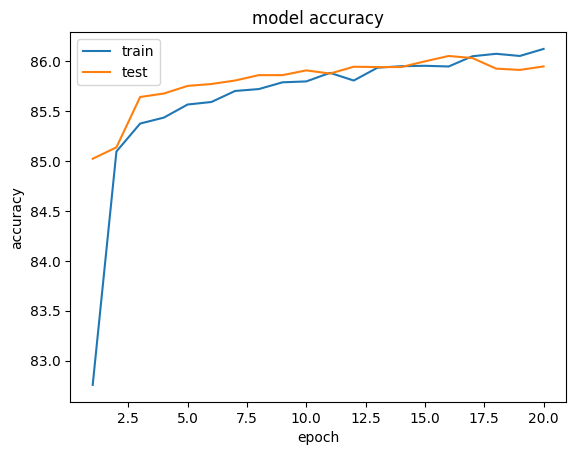

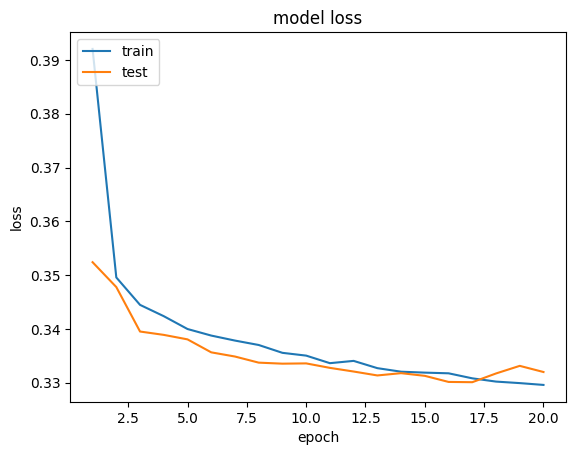

In [17]:
epochs = np.arange(EPOCHS)+1
# summarize history for accuracy
plt.plot(epochs, epoch_train_accuracy)
plt.plot(epochs, epoch_test_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(epochs, epoch_train_loss)
plt.plot(epochs, epoch_test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# run model inference on test data set
predict_array_test = model.predict(test_features)

# create ROC curve


1969/1969 [==============================] - 4s 2ms/step


In [19]:
fpr, tpr, threshold = roc_curve(test_labels[:,1], predict_array_test[:,1])

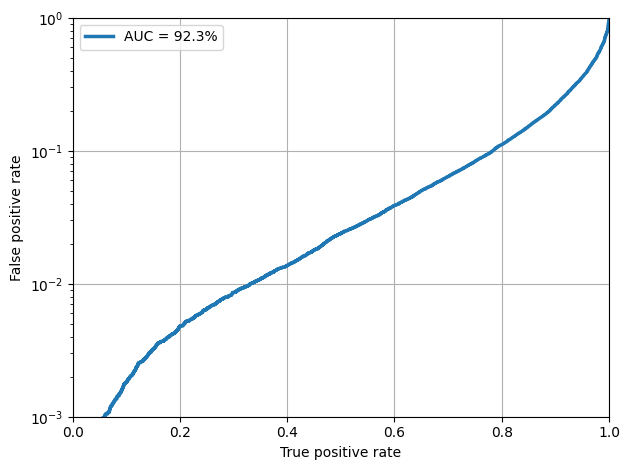

In [20]:
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')